## Deep Learning training with CNN and an extended FastText word embedding
We test here the combination of:
* an embedding layer which is initialized with a pretrained fasttext word embedding extended with custom embedding model
* a CNN layer to capture word sequence representation
* a dense layer to learn classification

We leverage the pre-trained fasttext word embedding model gracefully supplied by Facebook company at [https://github.com/facebookresearch/fastText/blob/master/pretrained-vectors.md](https://github.com/facebookresearch/fastText/blob/master/pretrained-vectors.md)

This general purpose word embedding model is extended with custom model generated by [fasttext_embedding_extension_builder.ipynb](fasttext_embedding_extension_builder.ipynb) script

In [1]:
# Keras
import keras
from keras.preprocessing.text import Tokenizer
import numpy as np
import pandas as pd
import sys
sys.path.append('..')
from utils import vizu
from utils import serializer

embeddings_index = {}

d:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
from sklearn.model_selection import train_test_split

XTrain = pd.read_csv('../../data/staging_data/mispelling_fixed_clean_input_train.csv', sep=',')
YTrain = pd.read_csv('../../data/POSOS/label.csv', sep=';')

XTrain, XTest, YTrain, YTest = train_test_split(XTrain, YTrain, test_size=0.15, random_state=42)
num_classes = 51

In [3]:
from keras.preprocessing.sequence import pad_sequences

vocabulary_size = 10000
sequence_length = 30
embedding_out_dims = 300

tokenizer = Tokenizer(num_words= vocabulary_size)
tokenizer.fit_on_texts(XTrain['question'])

sequences = tokenizer.texts_to_sequences(XTrain['question'])
XEncodedTrain = pad_sequences(sequences, maxlen=sequence_length)

In [4]:
# load the French fasttext model
import os, re, csv, math, codecs
from tqdm import tqdm

if len(embeddings_index) == 0:
    
    f = codecs.open('../../pretrained_models/fasttext/wiki.fr.vec', encoding='utf-8')
    for line in tqdm(f):
        values = line.rstrip().rsplit(' ')
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    f.close()

1152466it [02:24, 7996.02it/s]


In [5]:
# complete the embedding mode with the custom one built by the script additional_fasttext_embedding_builder.ipynb
customEmbedding = serializer.loadEmbeddingVector('../../pretrained_models/fasttext_embedding_extension.txt')

for k,v in customEmbedding.items():
    embeddings_index[k] = v 

In [6]:
nb_words = min(vocabulary_size, len(tokenizer.word_index))

embedding_matrix = np.zeros((nb_words+1, embedding_out_dims))

for word, i in tokenizer.word_index.items():
    if i >= nb_words:
        continue
                
    embedding_vector = embeddings_index.get(word)
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        embedding_matrix[i] = embedding_vector
    else:
        raise Exception("unknown word=" + word)

###  <b>Build neural network with CNN and FastText embedding<b>

In [56]:
# hyper-parameters
drop_ratio = 0.15
num_filters = 100
hidden_dims = num_filters

#kernel_sizes = [6,6,7, 6]
kernel_sizes = [6,6,6]
#pool_sizes= [6,6,8,14]
pool_sizes= [6,6,6]

batch_size = 20
num_epochs= 200

strides = 1
patience = 30

In [57]:
import keras
import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Dense, LSTM, Convolution1D, MaxPooling1D, Dropout, Flatten, Input, Concatenate
from keras.layers.embeddings import Embedding


# tensor flow technical setting
#config = tf.ConfigProto(device_count={"CPU": 32})
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.8, allow_growth = True)
config=tf.ConfigProto(gpu_options=gpu_options,allow_soft_placement=True)
keras.backend.tensorflow_backend.set_session(tf.Session(config=config))

# build the neural network
model = Sequential()

# word embedding loaded from fasttext+extension
model.add(Embedding(
    input_dim=len(tokenizer.word_index)+1,
    output_dim=embedding_out_dims,
    weights=[embedding_matrix],
    input_length=sequence_length,
    trainable=False))

model.add(Dropout(drop_ratio))

# sequential convolution/pooling with different kernel sizes
for kernel_size, pool_size in zip(kernel_sizes, pool_sizes):

    model.add(Convolution1D(
        filters=num_filters,
        kernel_size=kernel_size,
        strides=strides,
        data_format='channels_first',
        activation='relu'))
    
    model.add(MaxPooling1D(pool_size=pool_size))          
          
model.add(Flatten())

model.add(Dropout(drop_ratio))

# classification layer
model.add(Dense(hidden_dims, activation="relu"))

model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_15 (Embedding)     (None, 30, 300)           2429400   
_________________________________________________________________
dropout_28 (Dropout)         (None, 30, 300)           0         
_________________________________________________________________
conv1d_52 (Conv1D)           (None, 100, 295)          18100     
_________________________________________________________________
max_pooling1d_51 (MaxPooling (None, 16, 295)           0         
_________________________________________________________________
conv1d_53 (Conv1D)           (None, 100, 290)          9700      
_________________________________________________________________
max_pooling1d_52 (MaxPooling (None, 16, 290)           0         
_________________________________________________________________
conv1d_54 (Conv1D)           (None, 100, 285)          9700      
__________

### Train the network

In [31]:
YOneHotEncodedTrain = keras.utils.to_categorical(YTrain['intention'])

In [58]:
# generate the tensorflow board
call_back_board = keras.callbacks.TensorBoard(
    log_dir='c:/git/CES/logs',
    histogram_freq=0,
    batch_size=32,
    write_graph=True,
    write_grads=True,
    write_images=True,
    embeddings_freq=0,
    embeddings_layer_names=None,
    embeddings_metadata=None,
    embeddings_data=None)

# stop criterion to avoid overfitting
call_back_early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=patience,
    verbose=0,
    mode='auto',
    baseline=None)

call_back_reduce_learning_rate = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    patience=patience/2
)

# learn !
model.fit(
    XEncodedTrain,
    np.array(YOneHotEncodedTrain),
    validation_split=0.15,
    epochs = num_epochs,
    batch_size=batch_size,
    verbose=2,
    #callbacks = [call_back_early_stopping, call_back_board, call_back_reduce_learning_rate])
    callbacks = [call_back_early_stopping, call_back_board])


Train on 5799 samples, validate on 1024 samples
Epoch 1/200
 - 3s - loss: 3.2496 - acc: 0.2204 - val_loss: 3.2165 - val_acc: 0.2129
Epoch 2/200
 - 3s - loss: 3.0723 - acc: 0.2368 - val_loss: 2.9392 - val_acc: 0.2686
Epoch 3/200
 - 3s - loss: 2.5886 - acc: 0.3401 - val_loss: 2.3856 - val_acc: 0.3848
Epoch 4/200
 - 3s - loss: 2.0892 - acc: 0.4546 - val_loss: 2.1292 - val_acc: 0.4443
Epoch 5/200
 - 3s - loss: 1.7771 - acc: 0.5213 - val_loss: 1.9328 - val_acc: 0.5020
Epoch 6/200
 - 3s - loss: 1.5420 - acc: 0.5834 - val_loss: 1.8850 - val_acc: 0.5264
Epoch 7/200
 - 3s - loss: 1.3563 - acc: 0.6217 - val_loss: 1.8873 - val_acc: 0.5332
Epoch 8/200
 - 3s - loss: 1.2361 - acc: 0.6415 - val_loss: 1.8362 - val_acc: 0.5576
Epoch 9/200
 - 3s - loss: 1.1179 - acc: 0.6727 - val_loss: 1.8943 - val_acc: 0.5391
Epoch 10/200
 - 3s - loss: 0.9895 - acc: 0.7124 - val_loss: 1.9161 - val_acc: 0.5703
Epoch 11/200
 - 3s - loss: 0.9252 - acc: 0.7217 - val_loss: 1.8845 - val_acc: 0.5615
Epoch 12/200
 - 3s - loss:

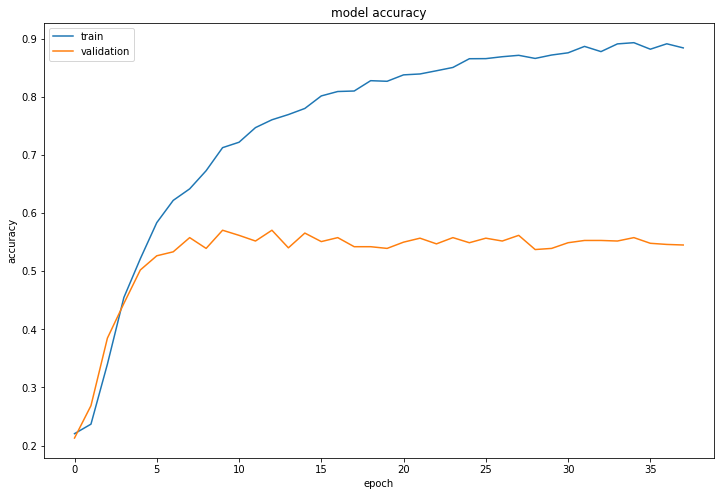

In [60]:
%matplotlib inline

vizu.plot_keras_model_learning_curve(model.history)

d:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


             precision    recall  f1-score   support

          0       0.30      0.46      0.36        35
          1       0.00      0.00      0.00         4
          2       0.20      0.20      0.20         5
          3       0.00      0.00      0.00         1
          4       1.00      0.73      0.84        11
          5       0.67      0.11      0.19        18
          6       0.50      0.75      0.60         4
          7       0.00      0.00      0.00         1
          8       0.82      0.56      0.67        25
          9       0.25      0.29      0.27         7
         10       0.44      0.33      0.38        12
         11       0.32      0.33      0.33        27
         12       0.07      0.33      0.11         6
         13       0.13      0.25      0.17        12
         14       0.27      0.29      0.28        42
         15       0.57      1.00      0.73         4
         16       0.00      0.00      0.00         3
         17       0.00      0.00      0.00   

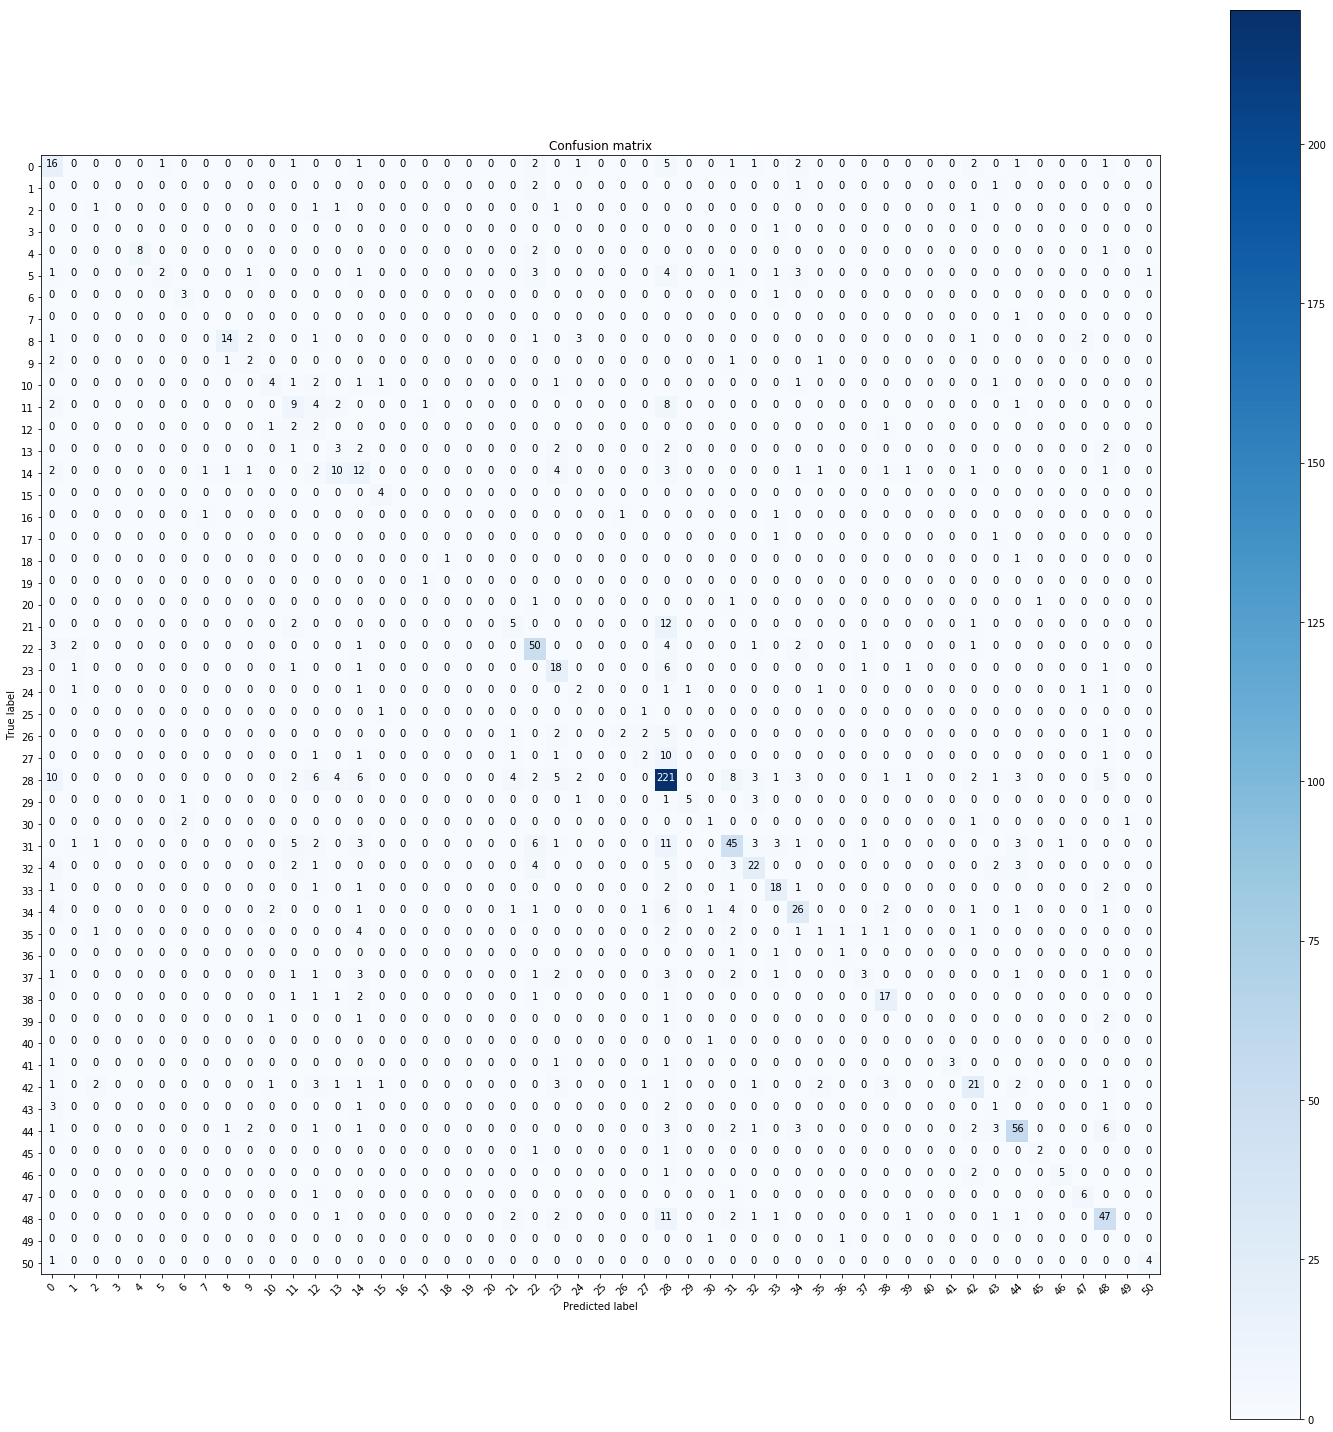

In [62]:
import sklearn
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

testSequences = tokenizer.texts_to_sequences(XTest['question'])
XEncodedTest = pad_sequences(testSequences, maxlen=sequence_length)
    
YTrue = YTest['intention']

YProba = model.predict(XEncodedTest)
YPredicted = YProba.argmax(axis=-1)


cnf_matrix = confusion_matrix(YTrue, YPredicted)

print(sklearn.metrics.classification_report(YTrue, YPredicted))

plt.figure(figsize=(20,20))

vizu.plot_confusion_matrix(cnf_matrix, normalize=False, classes = np.unique(YTrain['intention']))

plt.show()